# Model Analysis #

Author: Avery Blankenship

Date: 7/29/22

---

This notebook picks up where the core notebook left off to discuss analytical methods for working with word embedding models. In this notebook, we will be covering K-Means analysis, Principal Component Analysis (PCA) and T-Distributed Stochastic Neighbor Embedding (tSNE). This notebook assumes that you have already trained a model using Word2Vec as described in the [core notebook](core_notebook.ipynb).

While in the core notebook, we covered some of the ways you can query a model and how those queries can help you answer interesting research questions. Using some slightly more complicated analytical methods, however, allows you to get a better sense of the model as a whole. These analytical methods can help you target your research questions.

We're going to start by importing all of our libraries as well as our model.

In [20]:
import re                                               # for regular expressions
import os                                               # to look up operating system-based info
import string                                           # to do fancy things with strings
import glob                                             # to locate a specific file type
from pathlib import Path                                # to access files in other directories
import gensim                                           # to access Word2Vec
from gensim.models import Word2Vec                      # to access Gensim's flavor of Word2Vec
import pandas as pd                                     # to sort and organize data
from sklearn.decomposition import PCA                   # to import PCA algorithm
from matplotlib import pyplot                           # to visualize our data as graphs
from sklearn import cluster                             # to use k-means clustering
from sklearn import metrics                             # to use k-means clustering
from sklearn.manifold import TSNE                       # to generate a tsne plot
import numpy as np                                      # to do fancy things with numbers
import plotly.graph_objs as go                          # to visualize PCA
import matplotlib.pyplot as plt                         # to visualize plots
from mpl_toolkits.mplot3d import Axes3D                 # to visualize 3D plots

model = Word2Vec.load(r"C:\Users\avery\.spyder-py3\models\wordvector models\word2vectest.model")

# K-means Clustering

Cosine similarity is not the only way to calculate the distance between two vectors. Another method for performing this calculation is through k-means clustering. K-means clustering uses Euclidean distance rather than cosine similarity in order to determine how close two vectors are in vector space. 

Imagine that you have drawn a line connecting two points in vector space. Since both of these points are also connected to the origin point of the plot, by drawing a line to connect the two points, you've created a triangle. To calculate the cosine similarity of two points, the cosine of this new connecting line is calculated. In contrast, Euclidean distance calculates the _length_ of the line connecting the two points. As a result, whereas vectors tend to be more similar when the cosine of the two is larger, for Euclidean distance, a smaller number indicates a shorter line connecting the two vectors. The smaller the number is, the more similar two words are.

With this in mind, k-means clustering begins by picking a bunch of random points in vector space, called **centroids**, and seeing what vectors tend to be clustered together in those random locations. By calculating the Euclidean distance, the algorithm determines which points are closest to the centroids, which of them have the smaller Euclidean distances, while maintaining larger distances from other centroids. The algorithm tries to maintain some distance between clusters in order to ensure that they are unique. 

K-means is called "k-means" because some number of clusters (k) are used to calculate vector distance by taking the mean of all vectors within those clusters by adding the squared Euclidean distance between of all of the vectors within the cluster and the centroid.

Essentially, k-means clustering is calculating the distances between vectors in a way that is nearly the opposite of how built in functions such as the similarity function calculate the same thing. 

When working with word embedding models, k-means clustering can be useful in order to get a sense of what words tend to occupy the same general space. The centroids will be placed in vector space randomly, but since a crucial part of the k-means algorithm requires that vectors be distant from neighboring clusters, this ensures that there will likely be very minimal overlap between your sampling of random clusters. 

In this walkthrough, we are going to use the k-means algorithm that comes with the popular scikit-learn library in Python.

This code was adapted from Dylan Castillo’s [“How to Cluster Documents Using Word2Vec and K-means”.](https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/#cluster-documents-using-mini-batches-k-means)



### The Code ###

We're going to start off by just declaring a few variables. The first variable `VOCAB`, is going to hold our model's vocabulary. In Gensim 4.0, you retrieve the model's vocabulary by calling `model.wv.key_to_index`. In older versions of Gensim, you replace `key_to_index` with `vocab`. 

Next, we are going to declare `num_clusters` which is where we will determine how many random clusters we are wanting to retrieve using the k-means algorithm. 

Finally, we declare a variable `kmeans` that will hold the call to scikit-learn's k-means algorithm. As you can see, this algorithm initializes with some number of clusters, some number of iterations, and then is fitted to the vocabulary of your model. Like the training model code above, these are settings that you may wish to play around with. You can visit scikit-learn's [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to read more about additional settings that may be of use to you. 

In the actual call to the kmeans algorithm, there are a few parameters which you can change. 

__num_clusters__ -- this parameter represents the number of clusters (or centroids) you want to have. By default, this value is 8 though you can change the number to whatever you want. Keep in mind that for a smaller vocabulary, a smaller number of clusters might generate more useful data than a large number. I have chosen three in the code block below.

__max_iter__ -- this parameter represents the number of iterations you want the algorithm to complete in a single run. By default this parameter is set to 300 though you can change this number to whatever you like. I have chosen 40 iterations since the recipe model is relatively small.

There are a few additional optional parameters, though the two above are the move important. You can read about other parameters in the documentation. 

In [7]:
# vocab will hold our model's vocabulary
vocab = model.wv[model.wv.key_to_index]

# we are setting the number of clusters to 3. You can change this if you want
num_clusters = 3

# declare kmeans to hold the call to scikit-learn's kmeans algorithm
# by default, the algorithm sets the number of clusters to 8 and the max iterations to 300
# you can change the number of clusters or the number of max iterations 
kmeans = cluster.KMeans(n_clusters=num_clusters, max_iter=40).fit(vocab) 

The next set of variables we are going to declare are related to the clusters, themselves. The `centroids` variable, will hold the center points around which the clusters are arranged. You can imagine these centroids as points on a map that we have thrown random darts at. The centroids are generated by the kmeans algorithm as it runs. The way that we get access to these centroids is by using the `cluster_centers_` variable that the algorithm generates. This is somewhat similar to the way you call `model.wv` to get access to a model's word vectors.

Finally, we declare the `clusters_df` dataframe which will be used to store the words within in our random clusters. I am storing these clusters in a dataframe because it will allow me to preserve distinctions between clusters using columns and rows and will make saving the results to a `.csv` file very easy.

In [8]:
# set the centroids variable to the kmeans cluster centers
centroids = kmeans.cluster_centers_

# declare an empty dataframe
clusters_df = pd.DataFrame()

Now, using a `for` loop, we are going to visit each of the random clusters and gather some of the words within them. This `for` loop starts at the first cluster and will iterate through each of the clusters, stopping once it has finished with the last one.

As the `for` loop reaches a cluster, it calculates the most representative words within that cluster by using the `most_similar` function. The function is calculating the words that are most similar to the centroid of that cluster and returns the top 15 words. Those words are stored within a variable, `most_representative`.

Then, we declare a temporary dataframe, called `temp_df` that will store the ID of the current cluster and the words associated with that cluster. Saving both the cluster ID as well as the words allows us to remember which words came from which cluster and will make interpreting the results much easier later.

Next, the temporary dataframe is appended to our `clusters_df` dataframe and the cluster ID and list of words are printed to the console.

In [10]:
# iterate through each of the clusters
for i in range(num_clusters):
    
    # calculate the top fifteen most similar words within the current cluster
    most_representative = model.wv.most_similar(positive=[centroids[i]], topn=15)
    
    # store the cluster number and the most representative words in a temporary dataframe
    temp_df={'Cluster Number': i, 'Words in Cluster': most_representative}
    
    # add the items in the temporary dataframe to our bigger clusters dataframe which will hold all the clusters
    clusters_df = clusters_df.append(temp_df, ignore_index = True)
    
    # print the cluster id and the most representative words to the console
    print(f"Cluster {i}: {most_representative}")

Cluster 0: [('gizzards', 0.9984972476959229), ('fritters', 0.9981787204742432), ('pears', 0.9979210495948792), ('gather', 0.9976630806922913), ('feet', 0.9971857070922852), ('salmon', 0.997113049030304), ('puffpaste', 0.9970889091491699), ('frying', 0.9970337748527527), ('leave', 0.9970002174377441), ('proceed', 0.9968469142913818), ('walnuts', 0.9967073798179626), ('means', 0.9966728687286377), ('apple', 0.9966102838516235), ('rennet', 0.9965773820877075), ('real', 0.9965720176696777)]
Cluster 1: [('rosewater', 0.9932137727737427), ('saltpetre', 0.9928154945373535), ('sifted', 0.99215167760849), ('port', 0.9909716248512268), ('brandy', 0.9909578561782837), ('salaratus', 0.9899387955665588), ('cinnamon', 0.9880889654159546), ('cloves', 0.9877825975418091), ('adding', 0.9874756932258606), ('white', 0.9868232607841492), ('blades', 0.9866543412208557), ('madeira', 0.9851230382919312), ('powdered', 0.9848707318305969), ('allspice', 0.9846847653388977), ('sift', 0.9845116138458252)]
Cluster

In order to make our results a little easier to read and viewable later, we save the dataframe to a `.csv` by using the built in pandas function `.to_csv()`. This function will preserve the columns and rows within our `clusters_df` dataframe and can be opened in any editor that can work with spreadsheets such as Excel or Google Sheets. Currently, the results are saved as `random_clusters.csv` though you can change this filename to something more meaningful if need be.

The code block below saves the results to your current working directory, but if you want your results saved somewhere more specific, include the filepath with the call to `.to_csv()`

In [11]:
# this will output the random sampling of clusters into a CSV located in your current directory. 
# if you want the file to save somewhere else, just include that filepath in the csv name 
# (C:/Users/avery/Documents/random_clusters.csv for example)
clusters_df.to_csv("random_clusters.csv")  

### Interpreting the Results ###

K-means clustering is a useful way to identify patterns in your model that you may not have been aware of. Because of this, k-means clustering is a useful first step in your analysis because it can help you explore your data and the algorithm scales up to large datasets well. Since Word2Vec is an unsupervised algorithm, it can be difficult to determine how the algorithm has grouped words together without the exploratory phase. 

However, when using k-means clustering, you should be aware that the results of the clustering may be impacted by a few factors. For example, rather than ignoring outliers the k-means clustering algorithm includes outliers with all of the rest of the data. For this reason, an outlier case in your model may drag other words into a cluster in a way that is not automatically significant. Additionally, since you are being asked to manually select the number of clusters as well as the number of iterations, it may take a few tries to generate useful data. 

# Principal Component Analysis 

Another useful form of model analysis is PCA (principle component analysis). For a much more detailed breakdown of PCA, check out The Datasitter's Club's [write up on PCA](https://datasittersclub.github.io/site/dsc10.html).

In general, PCA is a dimensionality reduction algorithm. PCA is called PCA because it attempts to reduce a dataset to its **principal components**. Just as k-means differed in its mathematical approach from cosine similarities, PCA also takes a different approach to dealing with vectors. Rather than calcuate the length of a line or the cosine of an angle, PCA determines the principal components of a dataset by using _linear algebra_. The algorithm uses linear algebra to combine items within a dataset in order to produce new items that contain most of the information from the old items, or their principal components.

Whereas k-means and cosine similarity try to capture similarity or closeness, PCA is more concerned with capturing the largest amount of variance in a dataset. It does this by using **eigenvectors** to determine what the degree of variance is amongst items in a dataset. The PCA algorithm will continue to calculate these eigenvectors while trying to maintain the most variance between components as possible and discarding items that are less significantly variable. The items that we decide to keep are called **feature vectors**. These feature vectors are then plotted and represent the essential features of the dataset while reducing some of that dataset's bulk. Probably the best way to think of these components, is as a sifter that you dig into sand to filter out shells and rocks. Since there is so much sand, we don't necessarily care about including the sand in a description of what you were able to find with the sifter. We do care, however, about the unique shells and rocks, and those items can tell us more about the features of the beach than any individual grain of sand. 

For the code, we are going to use scikit-learn's built in PCA algorithm. 

### The Code ###

We are going to declare the variable `labels` which will hold the vocabulary of our model, but formatted as a list. We'll use this variable later when we are labeling the points on our PCA plot.

In [12]:
# declare label list to hold our model vocabulary
# the model vocabulary will be used to label the points plotted
labels = list(model.wv.key_to_index)

The next thing that we do is declare a variable `vectors` which will hold all of the vectors in our model. PCA is going to try and sift through all of the sand in our vectors in order to pull out the seashells and rocks that we're actually interested in, so we have to feed it all of the vectors to it can do so. Next, we declare a variable `pca` which will actually hold the PCA call from scikit-learn. The `PCA()` function takes one parameter, `n_components`, which is the number of components you want the plot to represent. I have set `n_components` to 2 which will generate a 2D plot.

Finally, we fit the PCA function to our particular model's vectors and let it start sifting.

In [18]:
# define a variable vectors which will hold the vectors within our model
vectors = model.wv[model.wv.key_to_index]
    
# define a variable pca which will hold the call to the PCA algorithm
# the number of components is set to 2
pca = PCA(n_components=2)
    
# declare a variable result which holds the outcome of the algorithm
result = pca.fit_transform(vectors)

After actually calculating the princpal components of our model's vectors, we want to actually do something with them. We're going to plot our 2D components on a graph which will allow us to actually see the shape of the model. Since this is a two dimensional graph, we need to define the x and y axis. We do this by assigning each of these axes a component to plot, which was produced by our `result` variable from above. 

Now that we have our x and y axes, we can plot them. We start by declaring a variable `figure` which will represent our plot. We set the size of our particular figure to `(8, 6)`, but you should feel free to play around with the sizing on your own. Different sizes may work better with your data depending on its size. Then, we declare a variable, `axis`. The `axis` variable will allow us to label each axis as well as access individual points on the plot, making labeling much easier.

We use the `axis` variable to tell the computer that we want a 2D graph, and that we want to produce a scatter plot using the values associated with the x and y axes, each of which contains one of our principal components. 

The `for` loop which follows is how we are going to label our points. Using the built in function `.text()` we tell the computer to visit each point on the plot, and assign the corresponding label from our `labels` list to that point. I've set the font to be italic, blue, and the font size to 10, but these values can be adjusted to your liking. You can also comment out the `for` loop if you want to look at the PCA graph without the labels. 

Finally, we label the x and y axes. For this walkthrough, I have simply labeled them "x axis" and "y axis" though these can be changed to whatever would be useful to you. 

We end the function by telling the computer to show us the resulting plot by using the built in `.show()` function. 

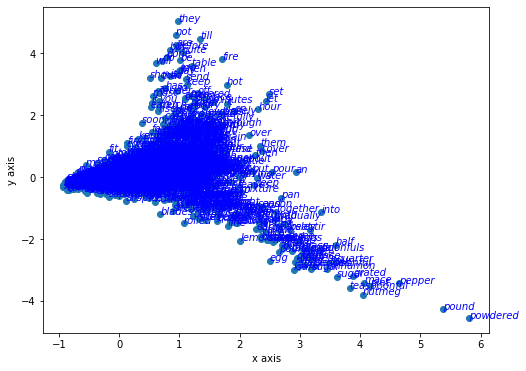

In [21]:
# create a scatter plot of the projection

# set the points for the x_axis by grabbing all the items in column one of the results variable
x_axis = result[:,0]

# set the points for the y_axis by grabbing all the items in column two of the results variable
y_axis = result[:,1]

# create a new figure of size (8, 6)
figure = plt.figure(figsize=(8, 6)) # you can change this size

# create a variable for the axes and let the computer know we want a 2D plot
axis = figure.add_subplot(111)

# scatterplot the points by using the x_axis variable as X and the y_axis variable as Y
axis.scatter(x_axis, y_axis)

# iterate through our labels list
for i in range(len(labels)):
        
    # assign labels to the points and make those labels italic, blue, and size 10
    axis.text(x_axis[i], y_axis[i], labels[i], style ='italic',
    fontsize = 10, color ="blue")  # you can change these values
        
# label the x axis
axis.set_xlabel('x axis') # you can change this

# label the y axis
axis.set_ylabel('y axis') # you can change this
   
# visualize the plot
plt.show()

While this code is pretty handy, if you want to change the model that is being analyzed, you would need to rerun all of your code. Having to rerun all of your code to reflect a single line change, for example, is not only inconvenient, but it is also not very memory efficient and will introduce unneccessary strain to your computer. 

In order to make rerunning the PCA code easier, we're going to surround the code above with a function definition. 

We are going to keep the bulk of the PCA code within a function that we will call `pca()`. Keeping the PCA code within a function ensures that we don't have to rerun the code if we want to apply PCA analysis to more than one dataset. In general, function definitions should be placed before any calls to use that function in the code. In order to define a function in python, you follow the format below:
    
`def function_name(parameter 1, parameter2):
    some code `
        
Then, you can call the function just like we've called built in functions in previous code by first writing the function name and then the parameters in parentheses: `function_name(parameter)`. In our case, we are going to define `pca()` as a function that accepts a model as its only parameter. This way, if you want to run the `pca()` function on a different model, you would just need to call `pca()` on your model of choice.

Before we define our function, we are going to declare the variable `labels`. We declare the `labels` variable outside of the PCA function for two reasons. First, by keeping `labels`outside of the function definition, we don't have to change anything about the PCA function if we want to change what the labels are. Second, it's a good practice to keep variables that aren't directly contributing to functionality of the function outside of its definition. 

We declare the `labels` variable outside of the PCA function for two reasons. First, by keeping `labels`outside of the function definition, we don't have to change anything about the PCA function if we want to change what the labels are. Second, it's a good practice to keep variables that aren't directly contributing to functionality of the function outside of its definition. 

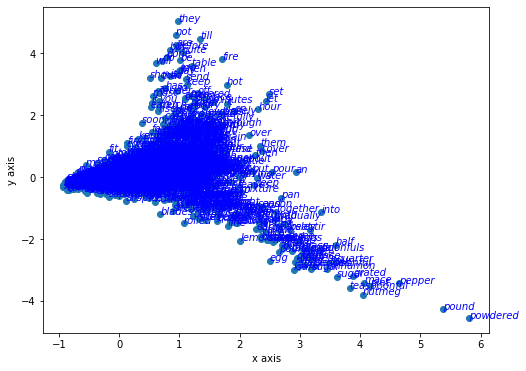

In [25]:
labels = list(model.wv.key_to_index)
def pca(model):
    vectors = model.wv[model.wv.key_to_index]  # get all the vectors
    pca = PCA(n_components=2)
    result = pca.fit_transform(vectors)
    # create a scatter plot of the projection
    x_axis = result[:,0]
    y_axis = result[:,1]
    figure = plt.figure(figsize=(8, 6))
    axis = figure.add_subplot(111)
    axis.scatter(x_axis, y_axis)
    for i in range(len(labels)):
        axis.text(x_axis[i], y_axis[i], labels[i], style ='italic',
        fontsize = 10, color ="blue")
    axis.set_xlabel('x axis')
    axis.set_ylabel('y axis')

    
    plt.show()

# here, we're actually calling the function
pca(model) 

As you can see, labeling every point on the PCA plot can make actually reading the labels quite difficult. Instead of labeling every point, we might want to plot all of our points and visualize a random number of them. In order to accomplish this, we are going to use the python library `random`. We are going to insert the code below into our `pca()` function to replace the `for` loop we previously used to label. 

First, we import `random` and then set the random number generator by using the built in function `.seed()`. The code `.seed(0)` tells the the computer to set the random number generator to begin at the number 0. We start at 0 because our indices begin at 0 rather than 1. 

Next, we declare a variable `all_indices` which will hold the indices for all vectors in our model. `all_indices` will be what we actually take a random sample from. We then declare a variable `selected_indices` which will hold our random sampling. In this instance, I am take a random sample of 25, though this number can be changed. 

Finally, we use a `for` loop to iterate through `selected_indices` and assign a label to the points in the corresponding locations.

In [31]:
# import random library
import random

# initiate random number generator
random.seed(0)

# grab all of the indices for our model vocabulary
all_indices = list(range(len(labels)))

# take a random sample of 25 indices
selected_indices = random.sample(all_indices, 25) # you can change this

# iterate through our random sample
for i in selected_indices:
        
    # label the corresponding random points
    axis.text(x_axis[i], y_axis[i], labels[i], style ='italic',
    fontsize = 14, color ="black") # change the font and font color to make the text more visible


The entire `pca()` function with a random sample of 25 items labeled is below:

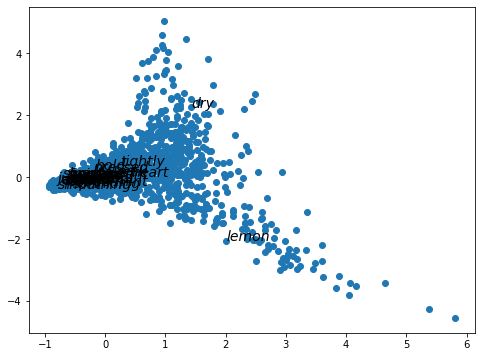

In [30]:
labels = list(model.wv.key_to_index)
def pca(model):
    vectors = model.wv[model.wv.key_to_index]  # get all the vectors
    pca = PCA(n_components=2)
    result = pca.fit_transform(vectors)
    # create a scatter plot of the projection
    x_axis = result[:,0]
    y_axis = result[:,1]
    figure = plt.figure(figsize=(8, 6))
    axis = figure.add_subplot(111)
    axis.scatter(x_axis, y_axis)

    import random
    random.seed(0)
    all_indices = list(range(len(labels)))
    selected_indices = random.sample(all_indices, 25) # you can change this
    for i in selected_indices:
        axis.text(x_axis[i], y_axis[i], labels[i], style ='italic',
        fontsize = 14, color ="black")

    
    plt.show()

# call the function
pca(model)

PCA plots can also be represented three-dimensionally which can often provide a different view of your model vocabulary. With the PCA plot represented three-dimensionally, you can get a better sense of the shape of the plot and where words are located in that space. The code is nearly the same as the two-dimensional plot above. The key difference between the two, is that instead of plotting an X and Y axis, we are going to plot a X, Y, and Z axis. The Z axis will represent the third dimension that we are adding to our plot.

Everything is nearly the same but you'll notice that in addition to defining the `x_axis` and `y_axis` variables, we are also going to define a variable `z_axis` which will pull vectors from the third column in our `result` variable. We also have set the number of components to 3 since this isa 3D graph.

In [33]:
# define a variable X which will hold the vectors within our model
vectors = model.wv[model.wv.key_to_index]
    
# define a variable pca which will hold the call to the PCA algorithm
# the number of components is set to 3
pca = PCA(n_components=3)
    
# declare a variable result which holds the outcome of the algorithm
result = pca.fit_transform(vectors)

# define x axis
x_axis = result[:,0]

# define y axis
y_axis = result[:,1]

# define z axis
z_axis = result[:,2]

Then, when we define our `ax` variable, we are going to tell the computer that we want a three-dimensional projection of our PCA plot. We do so by including `projection="3d"` in the `ax` definition.

In [35]:
axis_3d = figure.add_subplot(111, projection='3d')

Next, we're going to label a random sample of 25 points like we did above. This way, it's much easier to read the plot. We're going to use the random generator like in the above section, but we are going to add a Z axis to the label `for` loop. 

In [37]:
import random
random.seed(0)
all_indices = list(range(len(labels)))
selected_indices = random.sample(all_indices, 25) # you can change this
for i in selected_indices:
    axis_3d.text(x_axis[i], y_axis[i], z_axis[i], labels[i], style ='italic', # I added the z_axis here
    fontsize = 10, color ="blue")

Finally, we are going to label the z axis just like we labeled the x and y axes. Like before, these labels can be adjusted to better suit your corpus or data.

In [38]:
axis_3d.set_xlabel('x axis')
axis_3d.set_ylabel('y axis')
axis_3d.set_zlabel('z axis') # here is the z axis, the z axis info will print if you run this block

Text(0.5, 0, 'z axis')

The entire function definition is listed below. You can call this function just like the others by typing `pca(model)`

<IPython.core.display.Javascript object>


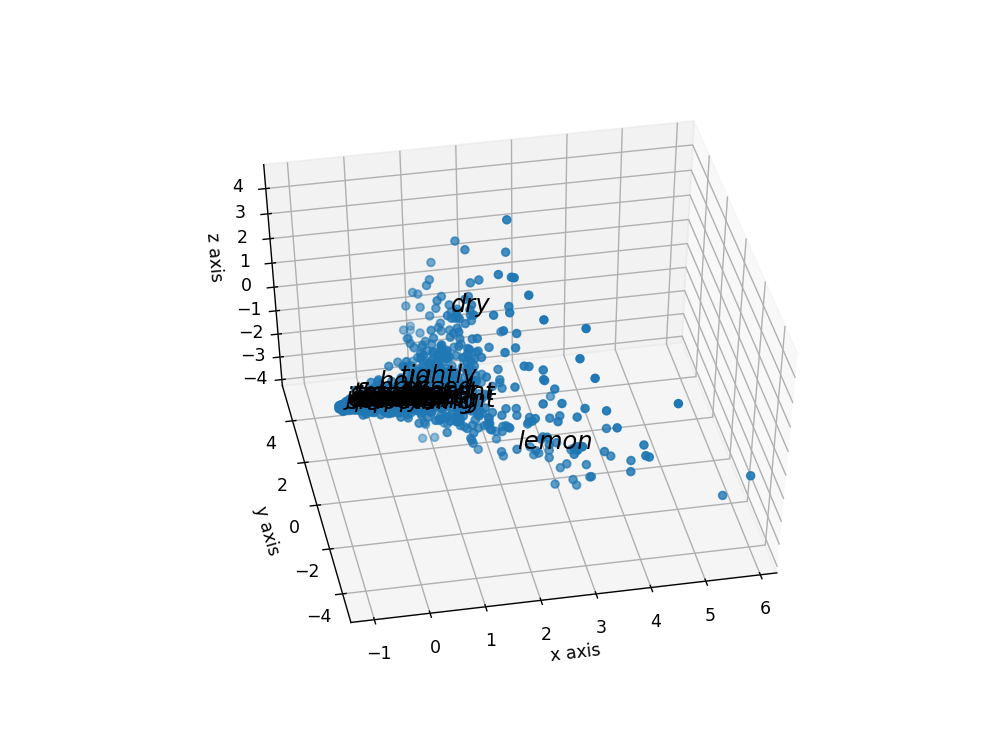

In [42]:
# the line below is just to make the graph interactive
# you can drag the graph around using your mouse to look at different angles
# click the stop button in the top right corner when you're done to create a static image
%matplotlib notebook
labels = list(model.wv.key_to_index)
def pca(model):
    vectors = model.wv[model.wv.key_to_index]  #get all the vectors
    pca = PCA(n_components=3)
    result = pca.fit_transform(vectors)
    # create a scatter plot of the projection
    x_axis = result[:,0]
    y_axis = result[:,1]
    z_axis = result[:,2]
    figure = plt.figure(figsize=(8, 6))
    axis_3d = figure.add_subplot(111, projection='3d')
    axis_3d.scatter(x_axis, y_axis, z_axis)
    import random
    random.seed(0)
    all_indices = list(range(len(labels)))
    selected_indices = random.sample(all_indices, 25) # you can change this
    for i in selected_indices:
        axis_3d.text(x_axis[i], y_axis[i], z_axis[i], labels[i], style ='italic',
        fontsize = 14, color ="black")
    axis_3d.set_xlabel('x axis')
    axis_3d.set_ylabel('y axis')
    axis_3d.set_zlabel('z axis')

    
    plt.show()
    
# call the function
pca(model)

### Interpreting PCA Results ###

A couple of things to keep in mind while you explore your new visualization are:

1. PCA results are usually discussed in terms of component scores. Component scores represent how significant a particular component is to the data. A high component score means that that particular component is highly influential

2. It can be useful to actually look at the components themselves and explore what types of words tend to be gathered by that component.

PCA can generally help you get a sense of how your data is shaped. However, PCA is not particularly useful for determining what individual clusters of words might be. In order to determine that, you should turn to tSNE analysis, which is particularly useful for getting a sense of how your data is grouped whereas PCA more so captures a sense of the data as a whole.

# tSNE Analysis ##

The final form of mathematical analysis that we will cover in this tutorial is tSNE analysis. T-distributed Stochastic Neighbourhood Embedding (tSNE) is a dimensionality reduction algorithm similar to PCA. However, while PCA is more concerned with preserving variance in a data set, tSNE cares more about things that are close together. Another important difference between tSNE and PCA, is that the results of tSNE analysis vary with each run. This is because tSNE is a probabilistic technique. tSNE is also always working in a two-dimensional space whereas PCA can work with many dimensions. 

However, while tSNE does differ in important ways from PCA, a researcher might find tSNE's ability to represent the shape of data more effectively more appealing than PCA. whereas PCA tends to mix data together and represent it as a singular grouping, tSNE often produces visualizations of clusters in a data set. This ability to represent these groupings can be helpful from an exploratory perspective as it allows researchers to see the variance in their data. While generally, it is recommended to start with PCA, following up a PCA graph with a tSNE analysis can help produce a more full picture of a word embedding model. 

tSNE, like our other methods of analysis, uses a different type of math in order to calculate the distances between vectors. While PCA uses eigenvectors and linear algebra to calculate distance, tSNE uses t-distributions, a technique from statistics. The algorithm begins by calculating the Euclidean distance and then calculates a probability distribution across these distances using t-distributions. The goal of the algorithm is to keep similar words close together in tSNE's two-dimensional space while maximizing the distance between words that are not similar.

Like with PCA, we are going to store our tSNE in a function in order to make applying it to our model easier. The code for this tSNE function is adapted from the code from [this tutorial](https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne)

tSNE works a little bit slower than PCA, so the code below may be slightly slower.

### The Code ###

We begin by declaring two lists, `tokens` and `labels`. We'll use these lists to keep track of the vectors and their labels for each item in the model. 

In [45]:
# two empty lists that we will use to hold some data later
labels = []
tokens = []

After those two lists are declared, we proceed to an `if` statement and a `for` loop. The `if` statement asks whether we have a focus word by checking if the `focus_word` variable is equal to `None` or not. If the `focus_word` is _not_ set to `None`, the function proceeds to calculate the top `n` (`n` is set to 50 in the function definition) most similar words to that focus word. The code then proceeds to add these 50 neighbors to the labels and tokens lists. 

If there is no focus word, the code cycles through the model's vocabulary and adds the words in the model to the labels and tokens lists respectively. 

This initial `if` statement allows you to perform tSNE analysis around a particular word or to focus on a particular area of the vector space. As we have walked through, if there is a focus word, then what gets added to the labels and tokens lists are the 50 nearest neighbors to that particular word. This approach limits the tSNE analysis to that particular word. If there is no focus word, then the tSNE analysis is performed on the entire model.

In [47]:
# we'll set focus_word to none for now
focus_word = None

# this if statement is for when there is a focus word
if focus_word is not None:
    
    # add the focus_word vector to the tokens list
    tokens.append(model.wv[focus_word])
    
    # add the focus word to the labels list
    labels.append(focus_word)
    
    # define a variable neighbors which holds the top 'n' most similar words to the focus word
    neighbors = model.wv.most_similar(focus_word, topn = n)
    
    # cycle through the neighbors variable
    for neighbor in neighbors:
            
        # add the vector for each neighbor to the tokens list
        tokens.append(model.wv[neighbor[0]])
            
    # add each word to the labels list
    labels.append(neighbor[0])

# if there is no focus word
else:
    
    # traverse through the model vocabulary
    for word in model.wv.key_to_index:
        
        # add each word vector to the tokens list
        tokens.append(model.wv[word])
        
        # add each word to the labels list
        labels.append(word)

Next, like in the PCA example, we declare a variable, `tsne_model`, to hold the function call to scikit-learn's tSNE algorithm. scikit-learn's tSNE function accepts a number of parameters which can impact how the algorithm traverses through your data: 

1. **n_components** -- This parameter cooresponds to how many dimensions the analysis should work in. The default is 2. 

2. **Perplexitiy** -- This parameter relates to the nearest neighbors in the analysis. It basically tries to guess how many neighbors a particular vector will have in order to balance the attention given to each vector. Scikit-learn suggests using numbers between 5 and 50

3. **init** -- This parameter allows you to suggest how the components will be calculated, either 'random' or by 'pca'

4. **n_iter** -- This parameter represents the number of times the algorithm should traverse through the data before producing the plot

5. **random_state** -- This parameter helps to prevent different results being produced with different runs of the algorithm

There are a number of additional optional parameters which you can view in scikit-learn's [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [48]:
# declare a variable, tsne_model, to hold the instance of the tSNE algorithm
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

# declare a variable, new_values, to hold the vectors from the tSNe analysis
new_values = tsne_model.fit_transform(tokens)

The rest of the code formats the vectors in `new_values` so that they can be plotted on a scatter plot. Then, the labels list is used to label each point. 

<IPython.core.display.Javascript object>


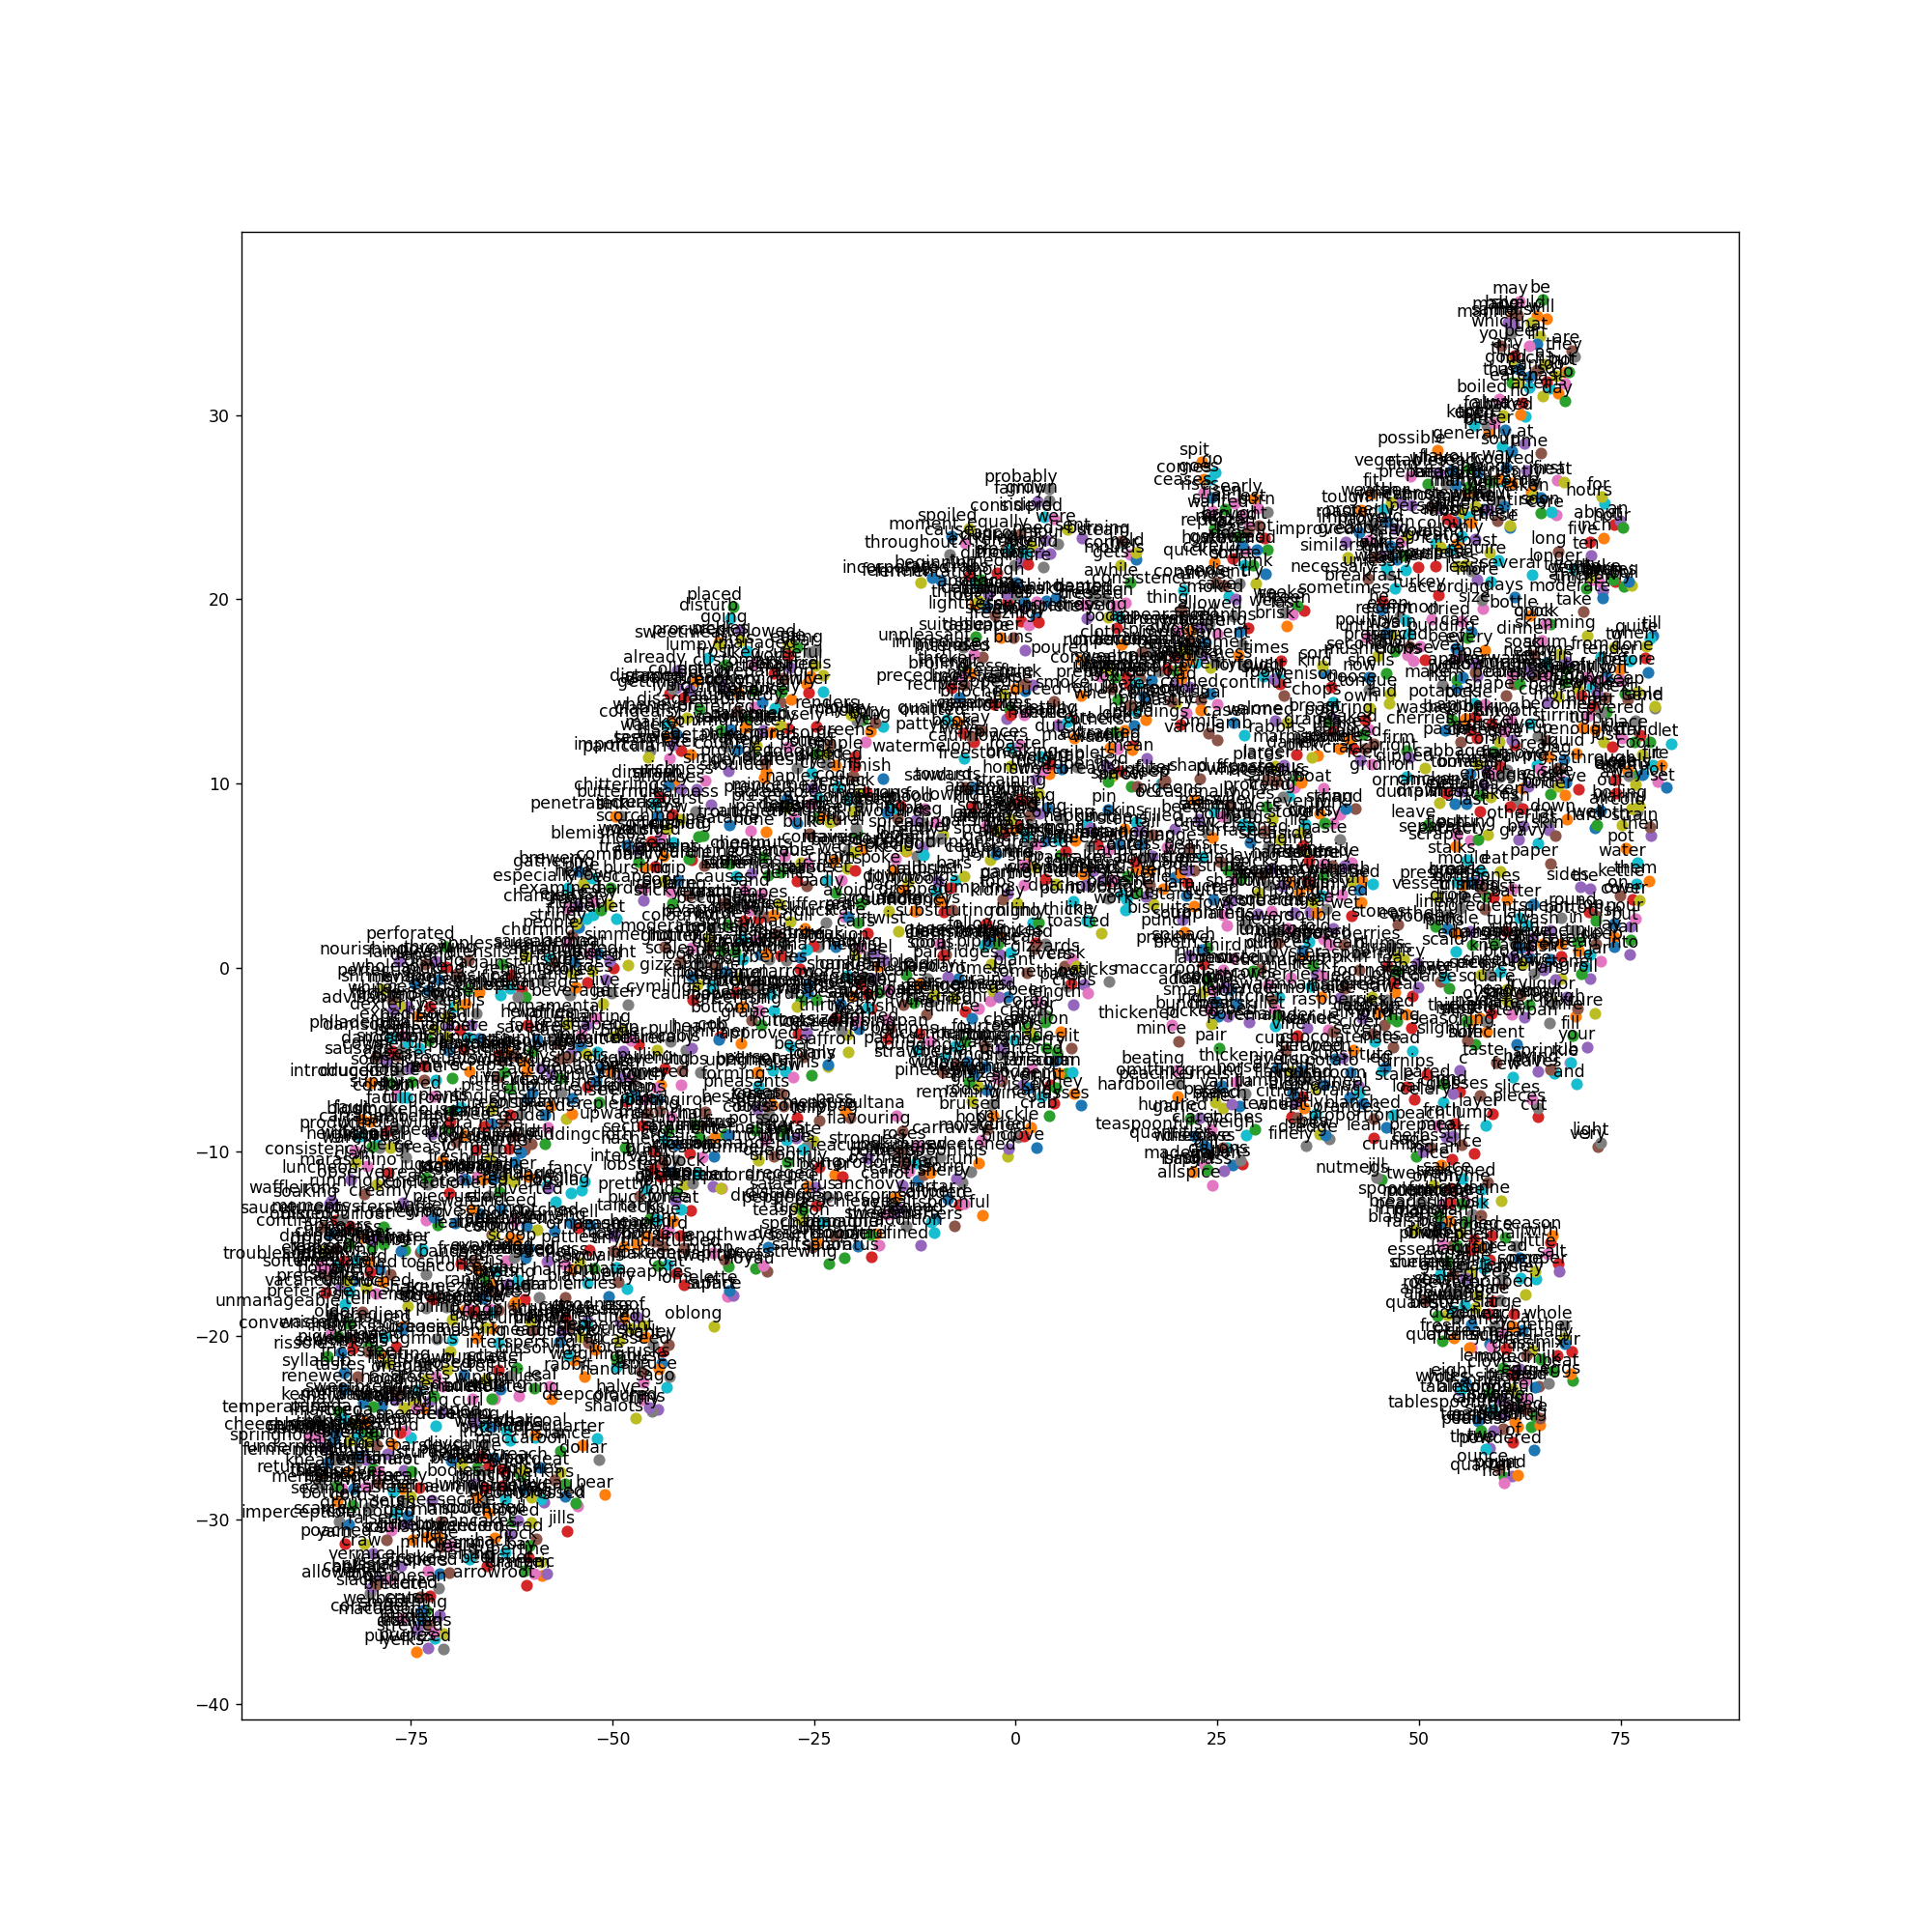

In [50]:
# define the x axis
x = [value[0] for value in new_values]

# define the y axis
y = [value[1] for value in new_values]
     
# set the size of the scatter plot
plt.figure(figsize=(16, 16)) 
    
# begin to plot each point and label it
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
# show the plot        
plt.show()

Just like in the PCA example, it would be much more efficient to have our tSNE analysis within a function definition so that we can run the code on different models and focus words without having to rerun all of the code. 

We begin by defining a function, `tsne()`, which accepts a model, a focus word, and a number of words as parameters. As you can see, `focus_word` is set to `none` by default and the number of words is set to 50. These parameters can be adjusted to suit your needs. For instance, if you are actually wanting the tSNE plot to be focused around a particular word, you can change `focus_word` to the word you are interested in. The definition looks like this:

    def tsne(model, focus_word = None, n = 50):
    
Just like the PCA analysis, you call the tSNE function by using `tsne(model)`. If I wanted to set a focus_word, I might instead use `tsne(model, focus_word="milk")`

All of the rest of the code is the same as above, just indented one line in to indicate that it is part of the function

<IPython.core.display.Javascript object>


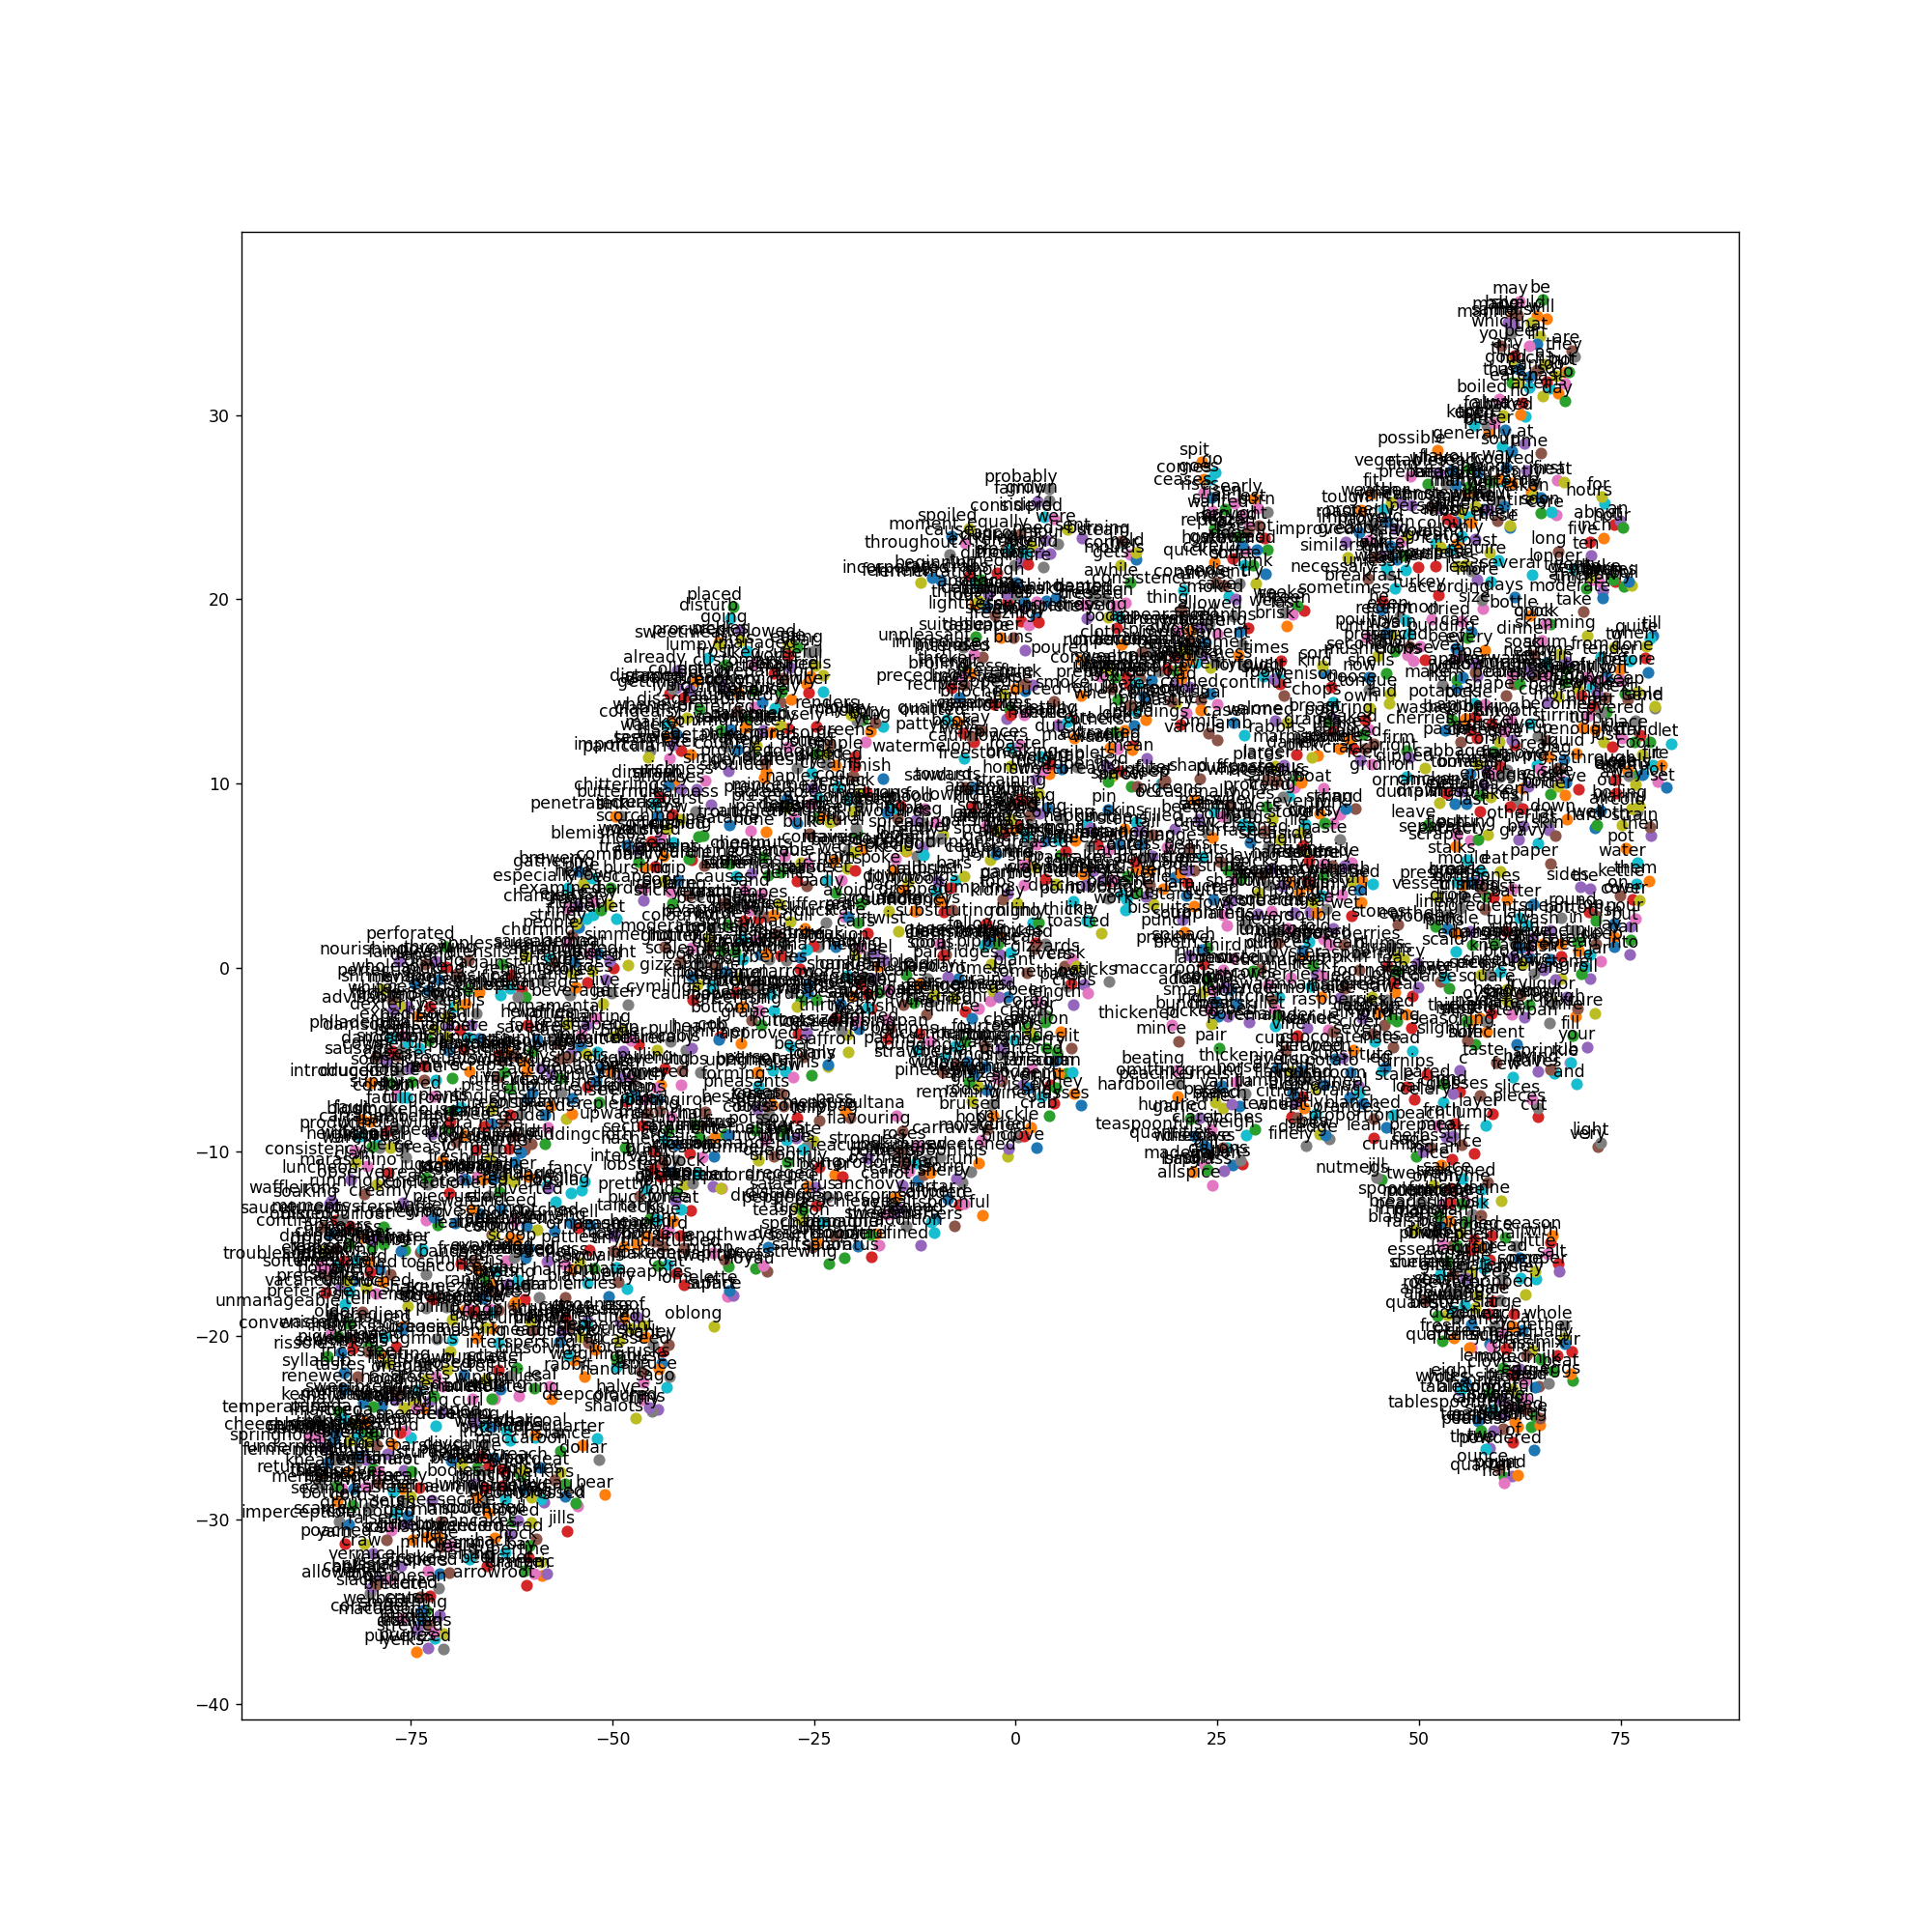

In [51]:
def tsne(model, focus_word = None, n = 50):
    labels = []
    tokens = []

    if focus_word is not None:
        tokens.append(model.wv[focus_word])
        labels.append(focus_word)
        neighbors = model.wv.most_similar(focus_word, topn = n)
        for neighbor in neighbors:
            tokens.append(model.wv[neighbor[0]])
            labels.append(neighbor[0])
    else:
        for word in model.wv.key_to_index:
            tokens.append(model.wv[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = [value[0] for value in new_values]
    y = [value[1] for value in new_values]
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                      xy=(x[i], y[i]),
                      xytext=(5, 2),
                      textcoords='offset points',
                      ha='right',
                      va='bottom')

    plt.show()
    
# call the function
tsne(model)

Because word embedding models contain quite a few words, labeling every point can make it difficult to actually analyze the plot. If you want to instead label just a few points, you can reformat your code like below by calling the random number generator like we did with the PCA function (that code snippet is just below)
    # only label a random set of 25 points
    import random
    random.seed(0)
    all_indices = list(range(len(labels)))
    selected_indices = random.sample(all_indices, 25) # you can change this
    for i in selected_indices:
        plt.annotate(labels[i],
                      xy=(x[i], y[i]),
                      xytext=(5, 2),
                      textcoords='offset points',
                      ha='right',
                      va='bottom')
    

<IPython.core.display.Javascript object>


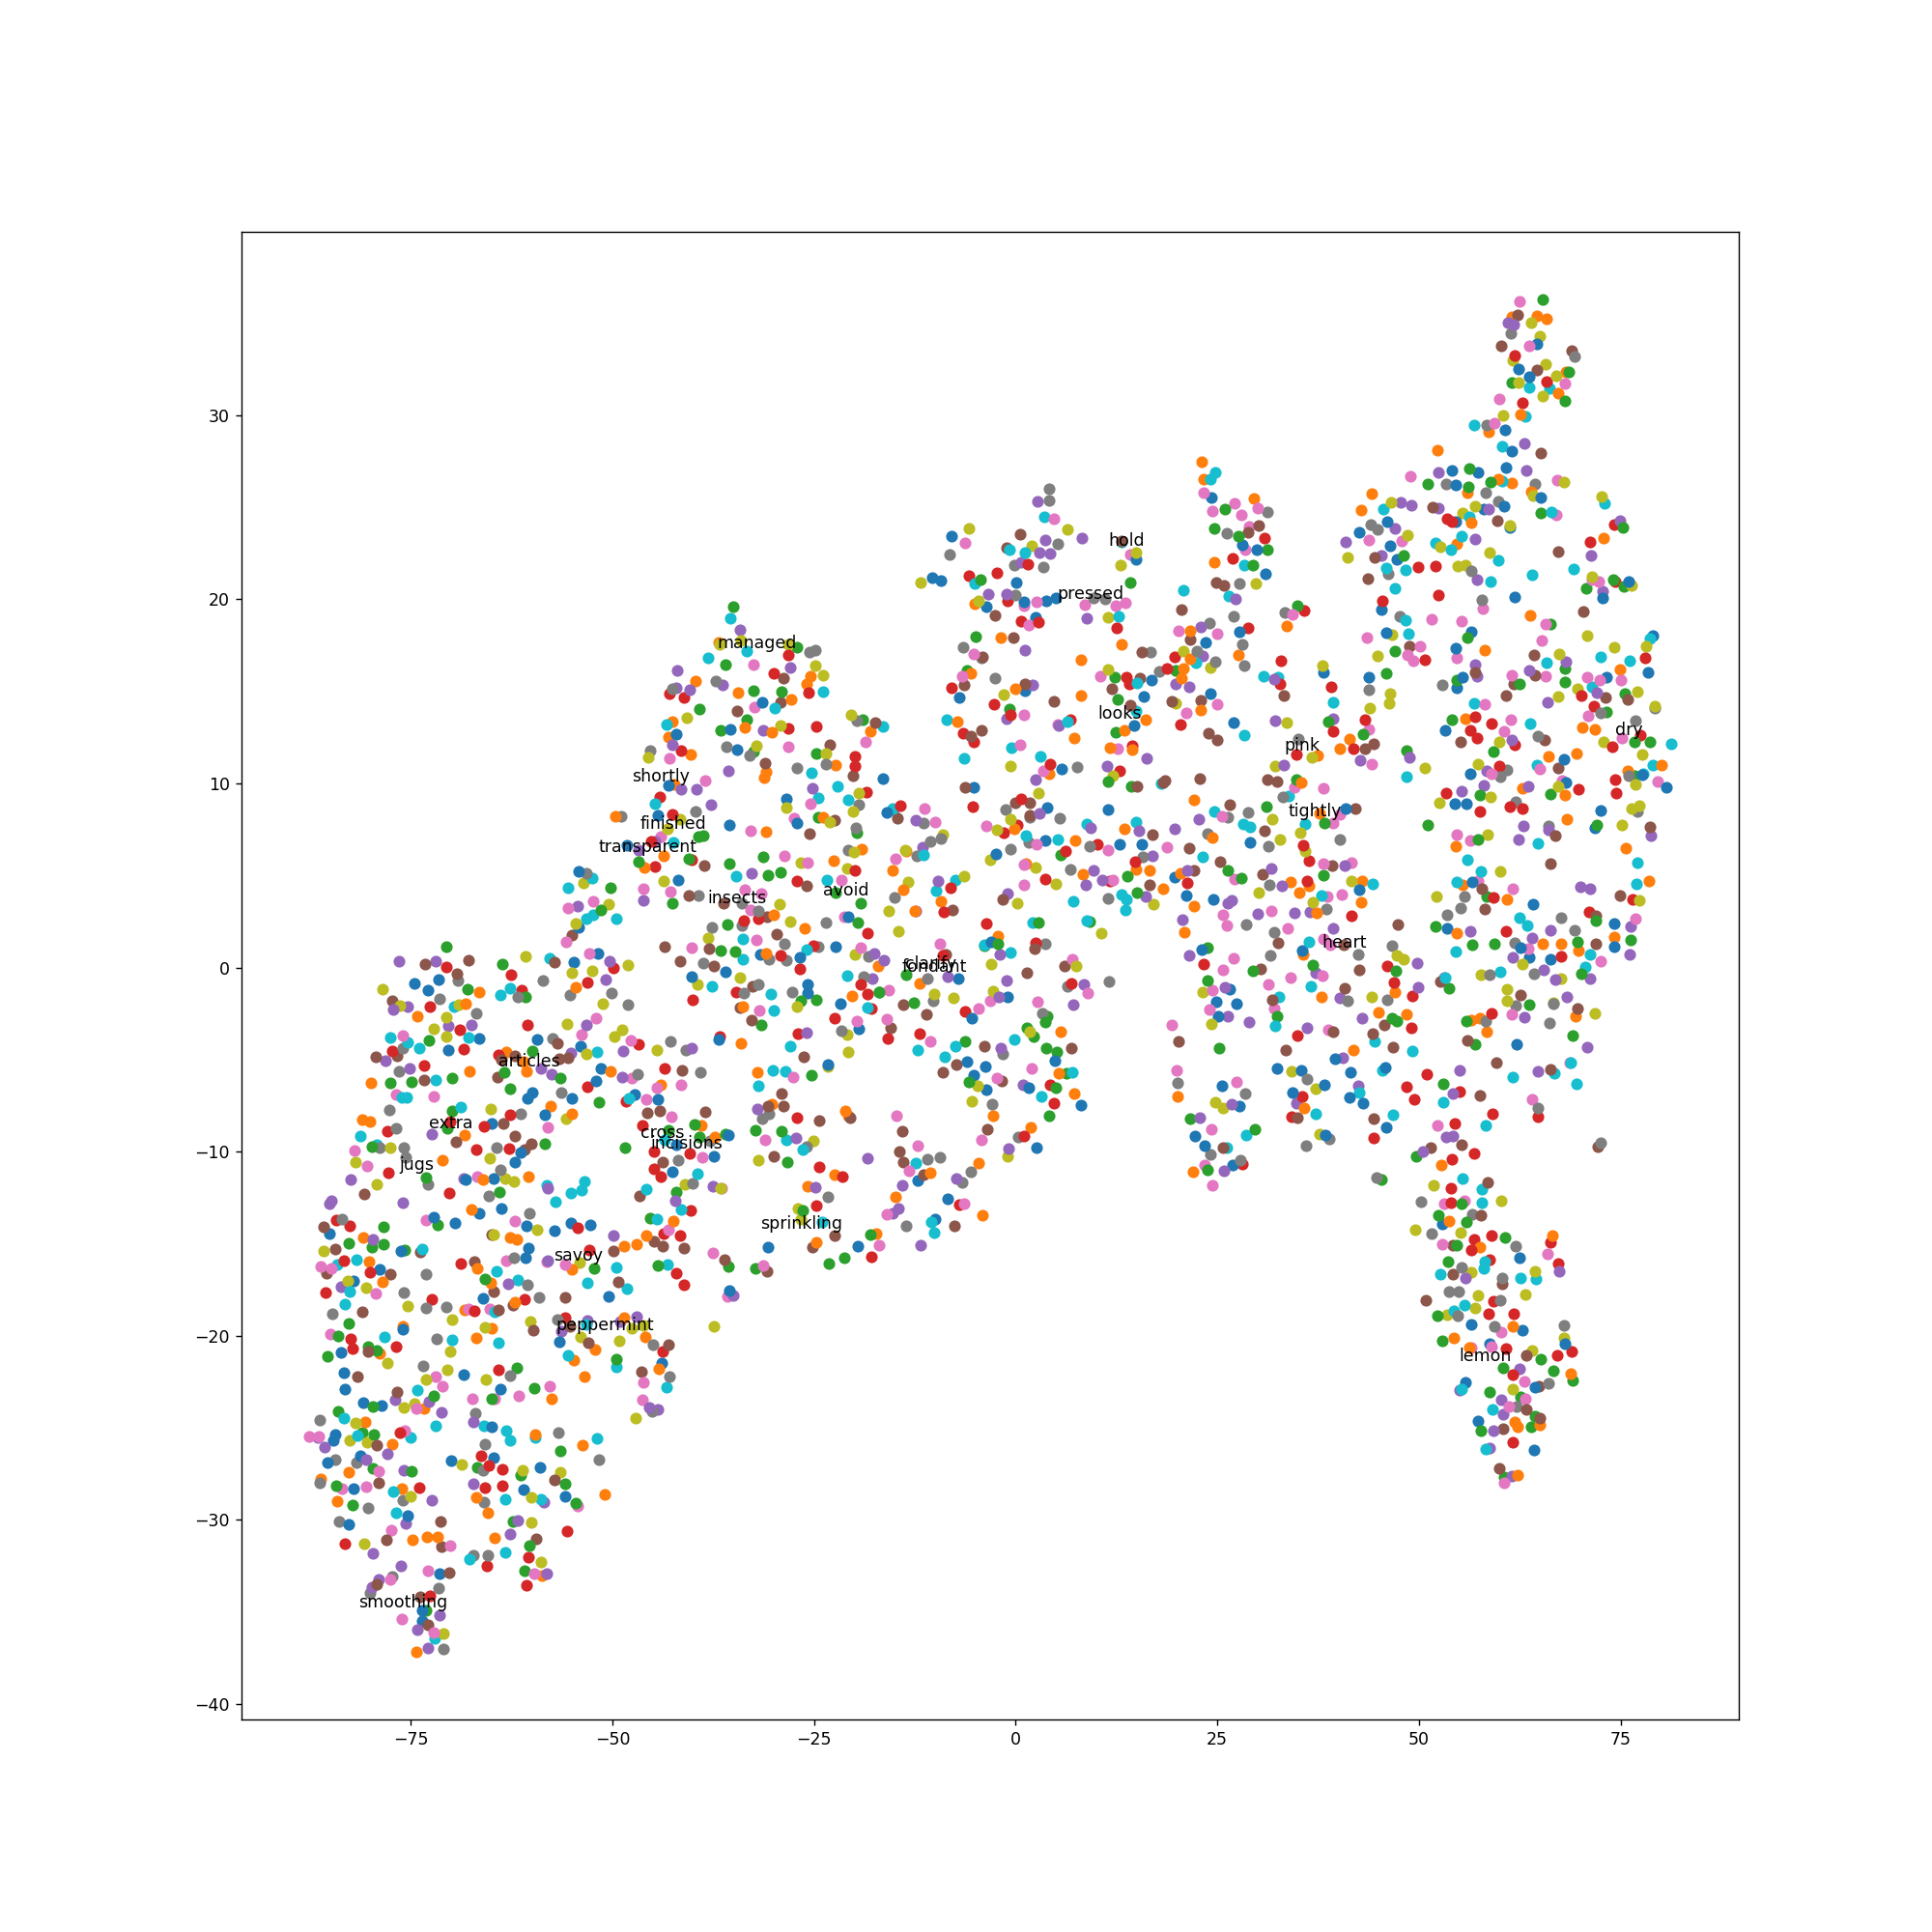

In [52]:
def tsne(model, focus_word = None, n = 50):
    labels = []
    tokens = []

    if focus_word is not None:
        tokens.append(model.wv[focus_word])
        labels.append(focus_word)
        neighbors = model.wv.most_similar(focus_word, topn = n)
        for neighbor in neighbors:
            tokens.append(model.wv[neighbor[0]])
            labels.append(neighbor[0])
    else:
        for word in model.wv.key_to_index:
            tokens.append(model.wv[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = [value[0] for value in new_values]
    y = [value[1] for value in new_values]
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        
    # only label a random set of 25 points
    import random
    random.seed(0)
    all_indices = list(range(len(labels)))
    selected_indices = random.sample(all_indices, 25) # you can change this
    for i in selected_indices:
        plt.annotate(labels[i],
                      xy=(x[i], y[i]),
                      xytext=(5, 2),
                      textcoords='offset points',
                      ha='right',
                      va='bottom')
    plt.show()
    
tsne(model)

### Interpreting tSNE ###

There are a few important things to note about interpreting the results of a tSNE analysis. 

1. tSNE is not deterministic, so your results may vary across runs of the same algorithm with the same settings. 

2. tSNE tries to average cluster sizes, so clusters may appear to be the same size in a visualization of the analysis when in actuality, they can vary quite a bit in size. This means that you cannot determine the size of a cluster based on tSNE alone

3. The distances between clusters may be meaningless. In addition, if you add new data to the corpus (for example if you retrain your word embedding model), you must also increase the perplexity in the tSNE analysis

The bottom line, is the tSNE will try to "clean up" it visualizations, so something that appear significant in the visualization may actually just be a result of this cleaning up. In order to get the most out of tSNE analysis, try running it multiple times and changing the hyperparameters. This will likely give you a more accurate picture of your data. 

# Conclusion #

As you can see, word embedding models are fairly versitile and powerful. Not only do these models enable you to capture the semantic significance of words in any particular corpus, but when analysis techniques are applied such as k-means clustering, PCA, or tSNE, it becomes much for evident how useful word embedding models are for representing the complexities of natural language. 

While this walkthrough focused in particular on a localized implementation of model analysis in Python, there are a number of tools online that are particularly useful for analyzing word embedding models. One tool in particular that is very useful is the [Tensorflow Projector](https://projector.tensorflow.org/). 

The Tensorflow Projector allows you to upload your model and produce interactive PCA and tSNE plots for your model. If you are interested in digging more deeply into the individual words reflected in tSNE or PCA, then the Projector is a great place to explore as its interactive features operate relatively quickly, even with large amounts of data. 

We also encourage you to continue learning about word embedding models through some of the great communities located in places such as Stackoverflow. Mutual aid is an essential feature of the coding community, and you should feel comfortable participating in that community, even as a beginner programmer. As we hope this walkthrough has demonstrated, the best work in programming happens when programmers work together. 

And finally, while this walkthrough is focused on Word2Vec, we also want to point to the newer Doc2Vec which can be implemented almost exactly how this walkthrough implements Word2Vec. Doc2Vec is a word embedding algorithm that produces vectors for sentences or entire documents by using something called "paragraph embeddings." If you are interested in training a model based on documents rather than individual words, we encourage you to check out Doc2Vec which comes preinstalled with Gensim. 


_This walkthrough was written on July 29th, 2022 using Python 3.8.3, Gensim 4.2.0, and Scikit-learn 0.23.1_